# Initialisation

In [1]:
""" Importing key libraries and modules """
import time
from datetime import datetime, timedelta

import numpy as np
import scipy.constants as con
import math
from uncertainties.umath import * # for mathematical operations, e.g. unumpy.sin(x)

import speasy as spz
import SerPyShock as SP
from data_functions import *
from calc_functions import *

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib widget

# Defining speasy databases for the spacecraft data
amda_tree = spz.inventories.tree.amda
cda_tree = spz.inventories.tree.cda
ssc_tree = spz.inventories.tree.ssc

## Input Satellite Data

These are the only parameters that need to be changed in the program:

- time_shock: the date and time of the shock we are looking at, (as detected by the spacecraft) in Universal Time
- name_spacecraft: the satellite we are looking at, (e.g. WIND in the solar wind)
- method: the method used to calculate the normal vector of the shock, (e.g. MX3)
- location: the location purely for printing purposes

In [2]:
""" Input date and time of the shock, and the period of analysis before and after """

# Date and time of the shock
time_shock = pd.to_datetime("2015-05-06 00:55:00")

# Name of the spacecraft, i.e. THEMIS cluster, WIND
name_spacecraft = "WIND"

# The method to be used in the analysis
method = "MX3"

# Where the shock is being located - purely for printing and figure purposes
location = "Solar Wind"

## Averaging Windows

These parameters are taken directly from Trotta (2022). "The ipshocks.fi catalogue uses windows of 8 minutes upstream and 8 minutes downstream of the shock, and they exclude 1 minute upstream and 2 minutes downstream of the shock."

In [3]:
""" Defining the variables for multiple averaging windows """

# Minutes observed before and after the shock
time_obs = 15
start_date = time_shock - timedelta(minutes = time_obs)
end_date = time_shock + timedelta(minutes = time_obs)

# Defining where the "upstream" and "downstream" regions are
# These are used to obtain the "upstream" and "downstream" quantity values, e.g. density-upstream
start_time_up  = time_shock  - timedelta(minutes = 9) # Largest upstream window start time
end_time_up = time_shock  - timedelta(minutes = 1)    # Largest upstream window end time
start_time_dw  = time_shock  + timedelta(minutes = 2) # Largest downstream window start time
end_time_dw = time_shock  + timedelta(minutes = 10)   # Largest downstream window end time

# Select minimum and maximum durations of the upstream and downstream windows for the systematic analysis
min_up_dur = timedelta(minutes = 2) # Duration of the smallest upstream window (time will span end_time_up - min_dur_up --> end_time_up + min_dur_up)
max_up_dur = end_time_up - start_time_up # Duration of the largest upstream window (do not edit)
min_dw_dur =  timedelta(minutes = 2) # Duration of the smallest downstream window (time will span start_time_down --> start_time_down + min_dur_down)
max_dw_dur = end_time_dw - start_time_dw # Duration of the largest downstream window (do not edit)
#Select the cadence by which the window lengths are increased (should be larger than the instrument plasma cadence)
tcad =  timedelta(seconds=20)

# Define the list of time up and down for our averaging range
window_up = (start_time_up, end_time_up)
window_dw = (start_time_dw, end_time_dw)

# Define variables used to plot the minimum and maximum windows
up_windows = (end_time_up - min_up_dur, end_time_up - max_up_dur)
dw_windows = (start_time_dw + min_dw_dur, start_time_dw + max_dw_dur)

# Main Program

## Retrieving Data

Retrieves the plasma parameters from the appropiate satellite and location using the Speasy routines.

In [4]:
if __name__ == "__main__":
    print("Analysing a shock detected by",name_spacecraft,"in the",location,"using the",method,"method\n")
    # Find the coordinates of the satellite
    satellite_info(name_spacecraft, time_shock)
    print()
    
    # Retrives the plasma parameters
    time_mag, B, B_unit = get_Bfield(name_spacecraft, start_date, end_date)
    B_up, B_dw = filter_up_dw(time_mag, B, window_up, window_dw)
    print_avg(B_up, "Upstream Magnetic Field", B_unit)
    print_avg(B_dw, "Downstream Magnetic Field", B_unit)
    print()
    
    time_vel, V, V_unit = get_velocity(name_spacecraft, start_date, end_date)
    V_up, V_dw = filter_up_dw(time_vel, V, window_up, window_dw)
    print_avg(V_up, "Upstream Bulk Flow", V_unit)
    print_avg(V_dw, "Downstream Bulk Flow", V_unit)
    print()
    
    time_rho, rho, rho_unit = get_density(name_spacecraft, start_date, end_date)
    rho_up, rho_dw = filter_up_dw(time_rho, rho, window_up, window_dw, 1)
    print_avg(rho_up, "Upstream Number Density", rho_unit, 1)
    print_avg(rho_dw, "Downstream Number Density", rho_unit, 1)
    print()
    
    time_pres, pres, pres_unit = get_pressure(name_spacecraft, start_date, end_date, rho)
    p_up, p_dw = filter_up_dw(time_pres, pres, window_up, window_dw, 1)
    print_avg(p_up*10**9, "Upstream Pressure", "nPa", 1)
    print_avg(p_dw*10**9, "Downstream Pressure", "nPa", 1)
    print()

Analysing a shock detected by WIND in the Solar Wind using the MX3 method

The time is: 2015-05-06 00:50:00
The satellite coordinates are: [237.92738659 -91.97729899  13.63589939]

Upstream Magnetic Field: [-0.7, 5.41, 2.0] ± [0.9, 0.3, 0.8] nT
Magnitude: 5.8±0.4 nT
Downstream Magnetic Field: [-2.5, 11.6, 3.6] ± [1.1, 1.8, 3.4] nT
Magnitude: 12.4±2.0 nT

Upstream Bulk Flow: [-378.0, -29.8, -8.0] ± [8.0, 3.3, 4.0] km/s
Magnitude: 380±8 km/s
Downstream Bulk Flow: [-453.0, -45.7, -21.0] ± [5.0, 1.5, 2.6] km/s
Magnitude: 456±5 km/s

Upstream Number Density: 5.9±2.2 cm-3
Downstream Number Density: 12.4±0.6 cm-3

Upstream Pressure: 0.0027±0.0021 nPa
Downstream Pressure: 0.0128±0.0013 nPa



## Shock Velocity

Calculates the speed of the shock using Trotta's multiple averaging windows method.

In [5]:
if __name__ == "__main__":
    print("Using Trotta's multiple averaging windows method and code\n")
    
    # Variable defined for the multiple averaging windows
    datetime_objects = pd.to_datetime(time_mag)
    freq = "ns"
    datetime_index = pd.DatetimeIndex(datetime_objects).floor(freq)
    
    # Extends/interpolates the data to match precision of B
    interp_V, ext_rho, ext_pres = extend_data(B, V, rho, pres)
    
    # Calculating the shock normal and speed, (and angle with the upstream magnetic field)
    avg_normal, avg_angle, avg_speed = SP_shock_speed(datetime_index, B, interp_V, ext_rho, time_shock, end_time_up, start_time_dw, min_up_dur, max_up_dur, min_dw_dur, max_dw_dur, tcad, method)
    print_data("Normal Vector in GSE", avg_normal)
    print_data("Angle", avg_angle, "degrees")
    print_data("Shock Speed", avg_speed, V_unit)

Using Trotta's multiple averaging windows method and code

Normal Vector in GSE: [-0.959, -0.218, -0.181] ± [0.008, 0.032, 0.018] 
Angle: 83±4 degrees
Shock Speed: 548±14 km/s


# Figures

## Shock Jump

This figure plots the data as seen in the frame of the spacecraft, (i.e. as the shock passes). We should see the characteristic "jump" for a shock. If we don't, then we aren't actually looking at a shock.

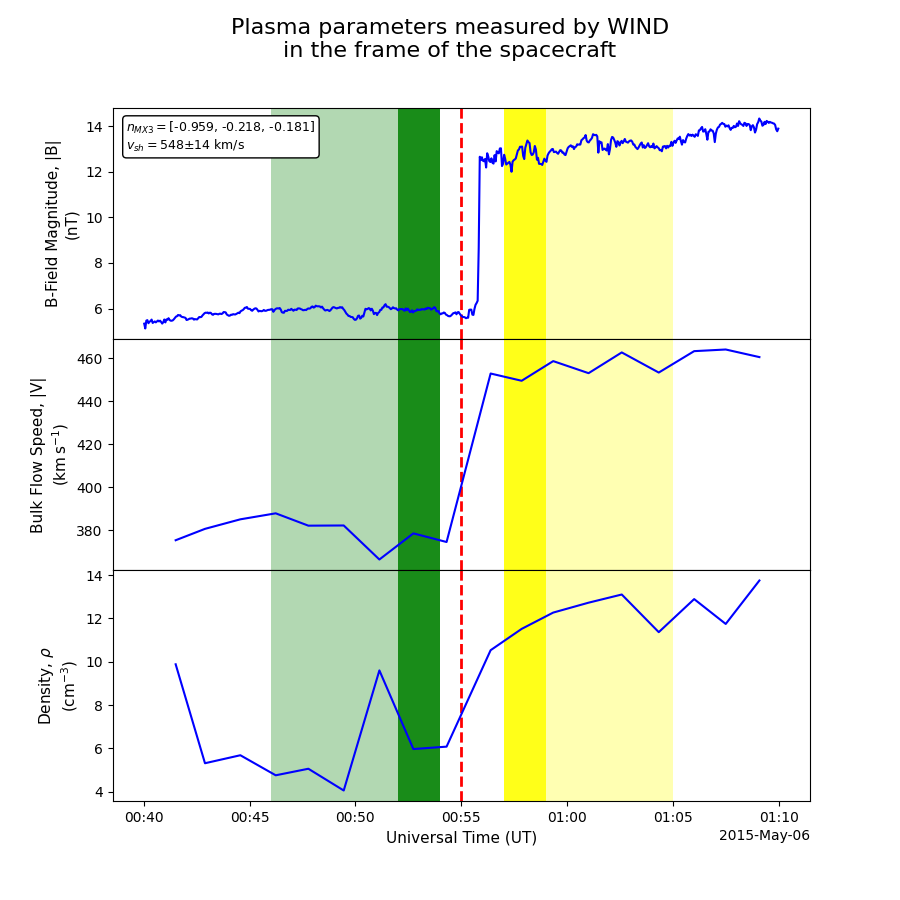

In [6]:
if __name__ == "__main__":
    # Figure parameters
    fig = plt.figure(figsize=(9, 9))
    gs = fig.add_gridspec(3, hspace=0)
    axes = gs.subplots(sharex=True, sharey=False)
    for axi in axes:
        plot_line(up_windows, dw_windows, end_time_up, start_time_dw, time_shock, ax=axi) # Plotting a vertical line for the shock

    axes[0].plot(time_mag, [magnitude(B_i) for B_i in B], color="blue", label = "|B|")
    axes[0].set_ylabel("B-Field Magnitude, |B|\n(nT)", fontsize = 11)

    axes[1].plot(time_vel, [magnitude(V_i) for V_i in V], color="blue", label = "|V|")
    axes[1].set_ylabel("Bulk Flow Speed, |V|\n"+r"($\mathrm{km\,s^{-1}}$)", fontsize = 11)

    axes[2].plot(time_rho, rho, color="blue", label = r"$\rho$")
    axes[2].set_ylabel("Density, "+r"$\rho$"+"\n"+r"($\mathrm{cm^{-3}}$)", fontsize = 11)
    
    # Figure information
    n_mean, n_err = vector_uarray(avg_normal)
    data_string = str(n_mean)
    normal_str = "\n".join((
        r"$n_{MX3}=$"+data_string,
        r"$v_{sh}=$"+"{:fP} ".format(avg_speed)+str(V_unit)))

    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle="round", facecolor="white", alpha=1)

    # place a text box in upper left in axes coords
    axes[0].text(0.02, 0.95, normal_str, transform=axes[0].transAxes, fontsize=9, verticalalignment="top", bbox=props)
    
    # Sets the x-axis labels to be easy to read
    axes[-1].set_xlabel("Universal Time (UT)",fontsize = 11)
    locator = mdates.AutoDateLocator()
    axes[-1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

    fig.suptitle(f"Plasma parameters measured by {name_spacecraft}\nin the frame of the spacecraft", fontsize = 16)
    
    #plt.close()